[Table of Contents](./table_of_contents.ipynb)

# Kalman Filter Math

In [1]:
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

Ha idáig eljutott, remélem, úgy gondolja, hogy a Kálmán-szűrő félelmetes hírneve némileg méltatlan. Természetesen néhány egyenletet félretettem, de remélem, a megvalósítás meglehetősen egyszerű volt az Ön számára. A mögöttes koncepció meglehetősen egyszerű – végezzen két mérést, vagy egy mérést és egy előrejelzést, és válassza ki a kimenetet úgy, hogy valahol a kettő között legyen. Ha jobban hiszi a mérést, akkor a tippje közelebb lesz a méréshez, és ha úgy gondolja, hogy az előrejelzés pontosabb, akkor a tippje közelebb áll hozzá. Ez nem rakétatudomány (kis vicc – pontosan ez a matematika juttatta Apollót a Holdra és vissza!). 

Őszintén szólva gondosan válogattam meg a problémáimat. Egy tetszőleges probléma esetén a Kálmán-szűrőmátrixok tervezése rendkívül nehéz lehet. Bár nem voltam túl trükkös*. Az olyan egyenletek, mint a Newton-féle mozgásegyenletek, triviálisan kiszámíthatók a Kalman-szűrő alkalmazásokhoz, és ezek alkotják a megoldani kívánt problémák nagy részét. 

A fogalmakat kóddal és érveléssel illusztráltam, nem matematikával. De vannak olyan témák, amelyek több matematikát igényelnek, mint amennyit eddig használtam. Ez a fejezet azt a matematikát mutatja be, amelyre a könyv további részében szüksége lesz.

## Dinamikus rendszer modellezése

A *dinamikus rendszer* olyan fizikai rendszer, amelynek állapota (helyzet, hőmérséklet stb.) idővel változik. A kalkulus a változó értékek matematikája, ezért differenciálegyenleteket használunk a dinamikus rendszerek modellezésére. Egyes rendszereket nem lehet differenciálegyenletekkel modellezni, de ebben a könyvben ezekkel nem fogunk találkozni.

A dinamikus rendszerek modellezése számos főiskolai képzés témája. Bizonyos mértékig semmi sem helyettesítheti a néhány féléves közönséges és parciális differenciálegyenletet, amelyet egy posztgraduális irányítási rendszerelmélet követ. Ha Ön hobbi, vagy egy nagyon specifikus szűrési problémát próbál megoldani a munkahelyén, valószínűleg nincs ideje és/vagy kedve egy vagy több évet ennek az oktatásnak szentelni.

Szerencsére eleget tudok bemutatni az elméletből ahhoz, hogy rendszeregyenleteket hozzunk létre sok különböző Kálmán-szűrőhöz. Célom, hogy eljusson arra a szintre, hogy el tudjon olvasni egy kiadványt, és elég jól megértse az algoritmusok megvalósításához. A matematikai háttér alapos, de a gyakorlatban néhány egyszerű technikát alkalmazunk. 

Ez a tiszta matematika leghosszabb része ebben a könyvben. Ebben a részben mindent el kell sajátítania, hogy megértse az Extended Kalman-szűrőt (EKF), a leggyakoribb nemlineáris szűrőt. Kitérek a modernebb szűrőkre, amelyek nem igényelnek annyi matematikát. Dönthet úgy, hogy most átfut, és visszatérhet ehhez, ha úgy dönt, hogy megtanulja az EKF-et.

A Kálmán-szűrő által használt mögöttes egyenletek és feltevések megértésével kell kezdenünk. Valós jelenségeket próbálunk modellezni, mit kell tehát figyelembe vennünk?

Minden fizikai rendszernek van folyamata. Például egy bizonyos sebességgel haladó autó meghatározott idő alatt eljut addig, és a sebessége a gyorsulás függvényében változik. Ezt a viselkedést a jól ismert newtoni egyenletekkel írjuk le, amelyeket a középiskolában tanultunk.

$$
\begin{aligned}
v&=at\\
x &= \frac{1}{2}at^2 + v_0t + x_0
\end{aligned}
$$

Miután megtanultuk a számítást, a következő formában láttuk őket:

$$ \mathbf v = \frac{d \mathbf x}{d t}, 
\quad \mathbf a = \frac{d \mathbf v}{d t} = \frac{d^2 \mathbf x}{d t^2}
$$

Egy tipikus autókövetési probléma a megtett távolság kiszámítása állandó sebesség vagy gyorsulás mellett, ahogy azt az előző fejezetekben tettük. De természetesen tudjuk, hogy ez nem minden, ami történik. Egyetlen autó sem halad tökéletes úton. Vannak egyenetlenségek, szélellenállás és dombok, amelyek növelik és csökkentik a sebességet. A felfüggesztés egy mechanikus rendszer, súrlódással és tökéletlen rugókkal.

Egy rendszer tökéletes modellezése lehetetlen, kivéve a legtriviálisabb problémákat. Kénytelenek vagyunk egyszerűsíteni. $t$ bármikor azt mondjuk, hogy a valódi állapot (például autónk helyzete) a tökéletlen modellből származó előrejelzett érték plusz néhány ismeretlen *folyamatzaj*:

$$
x(t) = x_{pred}(t) + noise(t)
$$

Ez nem azt jelenti, hogy a $noise(t)$ olyan függvény, amelyet analitikusan levezethetünk. Ez pusztán ténymegállapítás – a valódi értéket mindig úgy írhatjuk le, mint az előrejelzett értéket plusz a folyamatzaj. A „zaj” nem véletlenszerű eseményeket jelent. Ha egy eldobott labdát követünk a légkörben, és modellünk feltételezi, hogy a labda vákuumban van, akkor a légellenállás hatása ebben az összefüggésben folyamatzaj.

A következő részben megismerjük azokat a technikákat, amelyekkel magasabb rendű differenciálegyenletek halmazát elsőrendű differenciálegyenletek halmazává alakíthatjuk.  Az átalakítás után a rendszer zajmentes modellje:

$$ \dot{\mathbf x} = \mathbf{Ax}$$

A $\mathbf A$ a *rendszerdinamikai mátrix* néven ismert, mivel a rendszer dinamikáját írja le. Most modelleznünk kell a zajt. Ezt $\mathbf w$-nak hívjuk, és hozzáadjuk az egyenlethez. 

$$ \dot{\mathbf x} = \mathbf{Ax} + \mathbf w$$

A $\mathbf w$ rossz névválasztásnak tűnhet, de hamarosan látni fogja, hogy a Kálmán-szűrő *fehér* zajt feltételez.

Végül figyelembe kell vennünk a rendszerbe bevitt összes adatot. Feltételezzük a $\mathbf u$ bemenetet, és létezik egy lineáris modell, amely meghatározza, hogy ez a bemenet hogyan változtatja meg a rendszert. Például, ha megnyomja a gázpedált az autóban, az felgyorsul, és a gravitáció hatására golyók esnek le. Mindkettő vezérlő bemenet. Szükségünk lesz egy $\mathbf B$ mátrixra, hogy $u$-t a rendszer effektusává alakítsunk. Ezt hozzáadjuk az egyenletünkhöz:

$$ \dot{\mathbf x} = \mathbf{Ax} + \mathbf{Bu} + \mathbf{w}$$És ennyi. Ez az egyik egyenlet, amelyet Dr. Kálmán meg akart oldani, és talált egy optimális becslést, ha feltételezzük a $\mathbf w$ bizonyos tulajdonságait.

## Dinamikus rendszerek állapottér-ábrázolása

Levezettük az egyenletet

$$ \dot{\mathbf x} = \mathbf{Ax}+ \mathbf{Bu} + \mathbf{w}$$

Minket azonban nem a $\mathbf x$ deriváltja érdekel, hanem maga a $\mathbf x$. Ha egy pillanatra figyelmen kívül hagyjuk a zajt, olyan egyenletet akarunk, amely rekurzív módon megtalálja a $\mathbf x$ értékét $t_k$ időpontban $\mathbf x$ értékben $t_{k-1}$ időpontban:

$$\mathbf x(t_k) = \mathbf F(\Delta t)\mathbf x(t_{k-1}) + \mathbf B(t_k)\mathbf u (t_k)$$

A konvenció lehetővé teszi, hogy a $\mathbf x(t_k)$ $\mathbf x_k$-ként írjunk, ami azt jelenti, 
a $\mathbf x$ értéke a $k^{th}$ $t$ értéknél.

$$\mathbf x_k = \mathbf{Fx}_{k-1} + \mathbf B_k\mathbf u_k$$

A $\mathbf F$ az ismerős *állapot-átmeneti mátrix*, amely az állapot értékének diszkrét időlépések közötti átmeneti képessége miatt kapta a nevét. Nagyon hasonló a $\mathbf A$ rendszerdinamikai mátrixhoz. A különbség az, hogy a $\mathbf A$ lineáris differenciálegyenleteket modellez, és folytonos. A $\mathbf F$ diszkrét, és lineáris egyenletek (nem differenciálegyenletek) halmazát képviseli, amely $\mathbf x_{k-1}$-ból $\mathbf x_k$-ba vált át egy $\Delta t$ diszkrét időlépésben. 

Ennek a mátrixnak a megtalálása gyakran meglehetősen nehéz. A $\dot x = v$ egyenlet a lehető legegyszerűbb differenciálegyenlet, és triviálisan integráljuk a következőképpen:

$$ \int\limits_{x_{k-1}}^{x_k}  \mathrm{d}x = \int\limits_{0}^{\Delta t} v\, \mathrm{d}t $$
$$x_k-x_{k-1} = v \Delta t$$
$$x_k = v \Delta t + x_{k-1}$$

Ez az egyenlet *rekurzív*: a $x$ értékét a $k$ időpontban a $k-1$ időpontban érvényes értéke alapján számítjuk ki. Ez a rekurzív forma lehetővé teszi, hogy a rendszert (folyamatmodellt) a Kalman-szűrő által megkívánt formában ábrázoljuk:

$$\begin{aligned}
\mathbf x_k &= \mathbf{Fx}_{k-1}  \\
&= \begin{bmatrix} 1 & \Delta t \\ 0 & 1\end{bmatrix}
\begin{bmatrix}x_{k-1} \\ \dot x_{k-1}\end{bmatrix}
\end{aligned}$$

Ezt csak azért tudjuk megtenni, mert a $\dot x = v$ a lehető legegyszerűbb differenciálegyenlet. A fizikai rendszerekben szinte minden más bonyolultabb differenciálegyenletet eredményez, amely nem engedelmeskedik ennek a megközelítésnek. 

Az *állapot-tér* módszerek az Apollo-küldetések idején váltak népszerűvé, nagyrészt Dr. Kálmán munkájának köszönhetően. Az ötlet egyszerű. Modellezzünk egy rendszert $n^{th}$-rendű differenciálegyenletekkel. Alakítsa át őket elsőrendű differenciálegyenletek egyenértékű halmazává. Tedd őket az előző részben használt vektormátrix formába: $\dot{\mathbf x} = \mathbf{Ax} + \mathbf{Bu}$. Miután ebben a formában több technikát használunk, hogy ezeket a lineáris differenciálegyenleteket rekurzív egyenletté alakítsuk:

$$ \mathbf x_k = \mathbf{Fx}_{k-1} + \mathbf B_k\mathbf u_k$$

Egyes könyvek az állapotátmeneti mátrixot *alapvető mátrixnak* nevezik. Sokan a $\mathbf \Phi$-t használják a $\mathbf F$ helyett. Az erősen kontrollelméleten alapuló források általában ezeket a formákat használják.

Ezeket *állapottér* metódusoknak nevezzük, mert a differenciálegyenletek megoldását a rendszerállapotban fejezzük ki.

### Elsőrendű egyenletek kialakítása magasabb rendű egyenletekből

A fizikai rendszerek számos modellje másod- vagy magasabb rendű differenciálegyenleteket igényel vezérlő bemenettel$u$:

$$a_n \frac{d^ny}{dt^n} + a_{n-1} \frac{d^{n-1}y}{dt^{n-1}} +  \dots + a_2 \frac{d^2y}{dt^2} + a_1 \frac{dy}{dt} + a_0 = u$$Az állapottér módszerek elsőrendű egyenleteket igényelnek. Bármely magasabb rendű egyenletrendszer elsőrendűvé redukálható, ha a deriváltokhoz extra változókat definiálunk, majd megoldjuk. 


Vegyünk egy példát. Adott a rendszer$\ddot{x} - 6\dot x + 9x = u$keresse meg az ekvivalens elsőrendű egyenleteket. Az egyértelműség kedvéért a pontjelölést használtam az idő deriváltjaihoz.

Az első lépés a legmagasabb rendű tag elkülönítése az egyenlet egyik oldalára.$$\ddot{x} = 6\dot x - 9x + u$$Két új változót határozunk meg:$$\begin{aligned} x_1(t) &= x \\
x_2(t) &= \dot x
\end{aligned}$$Most ezeket behelyettesítjük az eredeti egyenletbe, és megoldjuk. A megoldás ezen új változók alapján egy elsőrendű egyenletet ad. Hagyományos a$(t)$a jelölések kényelme érdekében.

Ezt tudjuk$\dot x_1 = x_2$és azt$\dot x_2 = \ddot{x}$. Ezért$$\begin{aligned}
\dot x_2 &= \ddot{x} \\
         &= 6\dot x - 9x + u\\
         &= 6x_2-9x_1 + u
\end{aligned}$$Ezért elsőrendű egyenletrendszerünk az$$\begin{aligned}\dot x_1 &= x_2 \\
\dot x_2 &= 6x_2-9x_1 + u\end{aligned}$$Ha ezt egy kicsit gyakorolod, ügyes leszel benne. Izolálja le a legmagasabb tagot, határozzon meg egy új változót és származékait, majd helyettesítse.

### Elsőrendű differenciálegyenletek állapot-tér formában

Az újonnan definiált változók behelyettesítése az előző szakaszból:

$$\frac{dx_1}{dt} = x_2,\,  
\frac{dx_2}{dt} = x_3, \, ..., \, 
\frac{dx_{n-1}}{dt} = x_n$$

Az elsőrendű egyenletekbe a következőket kapjuk: 

$$\frac{dx_n}{dt} = \frac{1}{a_n}\sum\limits_{i=0}^{n-1}a_ix_{i+1} + \frac{1}{a_n}u
$$


A vektor-mátrix jelöléssel a következőket kapjuk:

$$\begin{bmatrix}\frac{dx_1}{dt} \\ \frac{dx_2}{dt} \\ \vdots \\ \frac{dx_n}{dt}\end{bmatrix} = 
\begin{bmatrix}\dot x_1 \\ \dot x_2 \\ \vdots \\ \dot x_n\end{bmatrix}=
\begin{bmatrix}0 & 1 & 0 &\cdots & 0 \\
0 & 0 & 1 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
-\frac{a_0}{a_n} & -\frac{a_1}{a_n} & -\frac{a_2}{a_n} & \cdots & -\frac{a_{n-1}}{a_n}\end{bmatrix}
\begin{bmatrix}x_1 \\ x_2 \\ \vdots \\ x_n\end{bmatrix} + 
\begin{bmatrix}0 \\ 0 \\ \vdots \\ \frac{1}{a_n}\end{bmatrix}u$$

amelyet ezután a következőképpen írunk le: $\dot{\mathbf x} = \mathbf{Ax} + \mathbf{B}u$.

### Az alapvető mátrix megtalálása az időinvariáns rendszerek számára

A rendszeregyenleteket állapottér formában fejezzük ki -val

$$ \dot{\mathbf x} = \mathbf{Ax}$$

ahol $\mathbf A$ a rendszerdinamikai mátrix, és meg akarja találni az *alapvető mátrixot* $\mathbf F$, amely a $\mathbf x$ állapotot továbbítja a $\Delta t$ intervallumon az egyenlettel

$$\begin{aligned}
\mathbf x(t_k) = \mathbf F(\Delta t)\mathbf x(t_{k-1})\end{aligned}$$

Más szavakkal, a $\mathbf A$ folytonos differenciálegyenletek halmaza, és a $\mathbf F$-nak olyan diszkrét lineáris egyenletnek kell lennie, amely kiszámítja a $\mathbf A$ változását egy diszkrét időlépés során.

Szokásos a $t_k$ és a $(\Delta t)$ elhagyása, és a jelölés használata

$$\mathbf x_k = \mathbf {Fx}_{k-1}$$

Általánosságban elmondható, hogy a Kálmán-szűrők mátrixának megtalálásának három általános módja van. A leggyakrabban használt technika az exponenciális mátrix. A lineáris időinvariáns elmélet, más néven LTI rendszerelmélet, egy második technika. Végül vannak numerikus technikák. Lehet, hogy ismer másokat, de ez a három az, amivel valószínűleg találkozni fog a Kálmán-szűrő irodalomban és gyakorlatban.

### A Mátrix exponenciális

Az egyenlet megoldása$\frac{dx}{dt} = kx$megtalálható:$$\begin{gathered}\frac{dx}{dt} = kx \\
\frac{dx}{x} = k\, dt \\
\int \frac{1}{x}\, dx = \int k\, dt \\
\log x = kt + c \\
x = e^{kt+c} \\
x = e^ce^{kt} \\
x = c_0e^{kt}\end{gathered}$$Amikor$t=0$, $x=x_0$. Helyettesítse ezeket a fenti egyenletre.$$\begin{gathered}x_0 = c_0e^{k(0)} \\
x_0 = c_01 \\
x_0 = c_0 \\
x = x_0e^{kt}\end{gathered}$$Hasonló matematikával az elsőrendű egyenlet megoldása$$\dot{\mathbf x} = \mathbf{Ax} ,\, \, \, \mathbf x(0) = \mathbf x_0$$ahol$\mathbf A$egy állandó mátrix, van$$\mathbf x = e^{\mathbf At}\mathbf x_0$$Helyettesítés$F = e^{\mathbf At}$, írhatunk$$\mathbf x_k = \mathbf F\mathbf x_{k-1}$$melyik a keresett forma! Az alapmátrix megtalálásának problémáját az érték megtalálásának problémájára redukáltuk$e^{\mathbf At}$.

$e^{\mathbf At}$[mátrix exponenciális] (https://en.wikipedia.org/wiki/Matrix_exponential) néven ismert. Ezzel a hatványsorral számítható ki:$$e^{\mathbf At} = \mathbf{I} + \mathbf{A}t  + \frac{(\mathbf{A}t)^2}{2!} + \frac{(\mathbf{A}t)^3}{3!} + ... $$Ezt a sorozatot a Taylor sorozat bővítésével találták meg$e^{\mathbf At}$, amire itt nem térek ki.

Használjuk ezt a megoldást a Newton-egyenletekre. Használata$v$helyettesítéseként$\dot x$, és állandó sebességet feltételezve a lineáris mátrix-vektor alakot kapjuk$$\begin{bmatrix}\dot x \\ \dot v\end{bmatrix} =\begin{bmatrix}0&1\\0&0\end{bmatrix} \begin{bmatrix}x \\ v\end{bmatrix}$$Ez egy elsőrendű differenciálegyenlet, így beállíthatjuk$\mathbf{A}=\begin{bmatrix}0&1\\0&0\end{bmatrix}$és oldja meg a következő egyenletet. Lecseréltem az intervallumot$\Delta t$számára$t$hangsúlyozni, hogy az alapmátrix diszkrét:$$\mathbf F = e^{\mathbf A\Delta t} = \mathbf{I} + \mathbf A\Delta t  + \frac{(\mathbf A\Delta t)^2}{2!} + \frac{(\mathbf A\Delta t)^3}{3!} + ... $$Ha végrehajtod a szorzást, akkor azt találod$\mathbf{A}^2=\begin{bmatrix}0&0\\0&0\end{bmatrix}$, ami azt jelenti, hogy minden magasabb ereje$\mathbf{A}$is$\mathbf{0}$. Így végtelen számú kifejezés nélkül pontos választ kapunk:$$
\begin{aligned}
\mathbf F &=\mathbf{I} + \mathbf A \Delta t + \mathbf{0} \\
&= \begin{bmatrix}1&0\\0&1\end{bmatrix} + \begin{bmatrix}0&1\\0&0\end{bmatrix}\Delta t\\
&= \begin{bmatrix}1&\Delta t\\0&1\end{bmatrix}
\end{aligned}$$Ezt bedugjuk$\mathbf x_k= \mathbf{Fx}_{k-1}$kapni$$
\begin{aligned}
x_k &=\begin{bmatrix}1&\Delta t\\0&1\end{bmatrix}x_{k-1}
\end{aligned}$$Ezt az állandó sebességű Kálmán-szűrőhöz analitikusan levezetett mátrixként ismeri fel a **Többváltozós Kalman-szűrő** fejezetben.

A SciPy linalg modulja egy "expm()" rutint tartalmaz a mátrix exponenciális kiszámításához. Nem a Taylor sorozat módszerét használja, hanem a [Padé Approximation] (https://en.wikipedia.org/wiki/Pad%C3%A9_approximant). Számos (legalább 19) módszer létezik a mátrix exponenciális kiszámítására, és mindegyik numerikus nehézségekkel küzd[1]. Tisztában kell lennie a problémákkal, különösen akkor, amikor$\mathbf A$nagy. Ha a "pade approximation mátrix exponenciális" kifejezésre keres, sok publikációt fog találni, amelyek ezzel a problémával foglalkoznak. 

A gyakorlatban ez nem feltétlenül érinti Önt, mivel a Kalman-szűrő esetében általában csak a Taylor-sorozat első két tagját vesszük figyelembe. De ne feltételezze, hogy a probléma kezelése befejeződött, és hagyja abba, és próbálja meg ezt a technikát más problémák kezelésére használni anélkül, hogy számszerűsítené ennek a technikának a teljesítményét. Érdekes módon a megoldás egyik kedvelt módja$e^{\mathbf At}$általánosított ódamegoldó használata. Más szóval, ők az ellenkezőjét teszik annak, amit mi teszünk – fordulnak$\mathbf A$differenciálegyenlet-halmazba, majd ezt a halmazt numerikus technikákkal oldja meg! 

Íme egy példa az "expm()" megoldásra$e^{\mathbf At}$.

In [3]:
import numpy as np
from scipy.linalg import expm

dt = 0.1
A = np.array([[0, 1], 
              [0, 0]])
expm(A*dt)

array([[1. , 0.1],
       [0. , 1. ]])

### Idő invariancia

Ha a rendszer viselkedése időfüggő, akkor azt mondhatjuk, hogy egy dinamikus rendszert az elsőrendű differenciálegyenlet ír le

$$ g(t) = \dot x$$

Ha azonban a rendszer *időinvariáns*, akkor az egyenlet a következő:

$$ f(x) = \dot x$$

Mit jelent az *időinvariáns*? Fontolja meg az otthoni sztereót. Ha a $x$ időpontban $t$ jelet visz be, akkor $f(x)$ jelet ad ki. Ha ehelyett a $t + \Delta t$ időpontban hajtja végre a bemenetet, a kimeneti jel ugyanaz lesz az $f(x)$ időben eltolva.

Ellenpélda: $x(t) = \sin(t)$, a $f(x) = t\,  x(t) = t \sin(t)$ rendszerrel. Ez nem időinvariáns; az érték különböző időpontokban eltérő lesz a t-vel való szorzás miatt.  A repülőgép nem időinvariáns. Ha egy későbbi időpontban vezérlő bemenetet ad meg a repülőgépnek, annak viselkedése más lesz, mert elégette az üzemanyagot, és így fogyott. Az alacsonyabb súly eltérő viselkedést eredményez.

Ezeket az egyenleteket az egyes oldalak integrálásával tudjuk megoldani. Fentebb bemutattam a $v = \dot x$ időinvariáns rendszer integrálását. A $\dot x = f(x)$ időinvariáns egyenlet integrálása azonban nem ilyen egyszerű. A *változók szétválasztása* technikát használva osztunk $f(x)$-tal, és a $dt$ tagot jobbra mozgatjuk, így az egyes oldalakat integrálni tudjuk:

$$\begin{gathered}
\frac{dx}{dt} = f(x) \\
\int^x_{x_0} \frac{1}{f(x)} dx = \int^t_{t_0} dt
\end{gathered}$$

Ha hagyjuk, hogy $F(x) = \int \frac{1}{f(x)} dx$, akkor azt kapjuk

$$F(x) - F(x_0) = t-t_0$$

Ezután megoldjuk x-et azzal

$$\begin{gathered}
F(x) = t - t_0 + F(x_0) \\
x = F^{-1}[t-t_0 + F(x_0)]
\end{gathered}$$

Más szavakkal, meg kell találnunk az $F$ inverzét. Ez nem triviális, és a STEM-oktatás során a tanfolyamok jelentős részét arra fordítják, hogy trükkös, elemző megoldásokat találjanak erre a problémára. 

Ezek azonban trükkök, és a $f(x)$ sok egyszerű formájának vagy nincs zárt formájú megoldása, vagy rendkívüli nehézségeket okoz. Ehelyett a gyakorló mérnök állapottér módszerekhez fordul, hogy megközelítő megoldásokat találjon.

Az exponenciális mátrix előnye, hogy tetszőleges, *időinvariáns* differenciálegyenlet-készlethez használhatjuk. Ezt a technikát azonban gyakran akkor is használjuk, ha az egyenletek nem időinvariánsak. Ahogy egy repülőgép repül, üzemanyagot éget és fogy. Az egy másodperc alatti fogyás azonban elhanyagolható, így a rendszer ezen időlépésen belül majdnem lineáris. Válaszaink továbbra is meglehetősen pontosak lesznek, amíg az időlépés rövid.

#### Példa: Mass-Ring-Damper Model

Tegyük fel, hogy nyomon akarjuk követni egy súly mozgását egy rugón, és egy lengéscsillapítóhoz, például egy autó felfüggesztéséhez kapcsoljuk. A mozgás egyenlete, ahol $m$ a tömeg, $k$ a rugóállandó és $c$ a csillapítóerő, valamilyen $u$ bemenet mellett 

$$m\frac{d^2x}{dt^2} + c\frac{dx}{dt} +kx = u$$

A jelölési kényelem kedvéért ezt így írom

$$m\ddot x + c\dot x + kx = u$$

Ezt elsőrendű egyenletrendszerré alakíthatom úgy, hogy beállítom a $x_1(t)=x(t)$ értéket, majd behelyettesítem a következőképpen:

$$\begin{aligned}
x_1 &= x \\
x_2 &= \dot x_1 \\
\dot x_2 &= \ddot x_1 = \ddot x
\end{aligned}$$

Ahogy az lenni szokott, a jelölési kényelem kedvéért elhagytam a $(t)$-t. Ez adja az egyenletet

$$m\dot x_2 + c x_2 +kx_1 = u$$

A $\dot x_2$ megoldásával egy elsőrendű egyenletet kapunk:

$$\dot x_2 = -\frac{c}{m}x_2 - \frac{k}{m}x_1 + \frac{1}{m}u$$

Ezt mátrix formába tesszük:

$$\begin{bmatrix} \dot x_1 \\ \dot x_2 \end{bmatrix} = 
\begin{bmatrix}0 & 1 \\ -k/m & -c/m \end{bmatrix}
\begin{bmatrix} x_1 \\ x_2 \end{bmatrix} + 
\begin{bmatrix} 0 \\ 1/m \end{bmatrix}u$$

Most az exponenciális mátrixot használjuk az állapotátmeneti mátrix megkereséséhez:

$$\Phi(t) = e^{\mathbf At} = \mathbf{I} + \mathbf At  + \frac{(\mathbf At)^2}{2!} + \frac{(\mathbf At)^3}{3!} + ... $$

Az első két kifejezés megadja nekünk

$$\mathbf F = \begin{bmatrix}1 & t \\ -(k/m) t & 1-(c/m) t \end{bmatrix}$$

Ez lehet, hogy nem ad kellő pontosságot. Ezt egyszerűen ellenőrizheti, ha kiszámítja a $\frac{(\mathbf At)^2}{2!}$ konstansokat, és megnézi, hogy ez a mátrix mennyiben járul hozzá az eredményekhez.

### Lineáris időinvariáns elmélet

Az [*Linear Time Invariant Theory*](https://en.wikipedia.org/wiki/LTI_system_theory), más néven LTI rendszerelmélet, lehetőséget ad arra, hogy megtaláljuk a $\Phi$-t az inverz Laplace-transzformáció segítségével. Most vagy bólogatsz, vagy teljesen elveszett.  Ebben a könyvben nem fogom a Laplace-transzformációt használni. Az LTI rendszerelmélet ezt mondja nekünk 

$$ \Phi(t) = \mathcal{L}^{-1}[(s\mathbf{I} - \mathbf{A})^{-1}]$$

Nem áll szándékomban ebbe belemenni, csak azt mondom, hogy a $\mathcal{L}$ Laplace-transzformáció a jelet $s$ térré alakítja, amely kizárja az időt, de a fenti egyenletre megoldást találni nem triviális. Ha érdekel, a Wikipédia LTI rendszerelméletről szóló cikke nyújt bevezetőt. Azért említem meg az LTI-t, mert talál néhány szakirodalmat, amely segítségével nehéz problémákra Kálmán szűrőmátrixokat tervezhet.

### Numerikus megoldások

Végül vannak numerikus technikák a $\mathbf F$ megkeresésére. Ahogy a szűrők egyre nagyobbak lesznek, az analitikai megoldások keresése nagyon unalmassá válik (bár a SymPy-hoz hasonló csomagok ezt megkönnyítik). C. F. van Loan [2] kifejlesztett egy technikát, amely számszerűen megtalálja a $\Phi$ és a $\mathbf Q$ értékeket is. Adott a folytonos modell

$$ \dot x = Ax + Gw$$

ahol $w$ az egységnyi fehér zaj, van Loan módszere a $\mathbf F_k$ és a $\mathbf Q_k$ értéket is kiszámítja.
    
A van Loan metódusát implementáltam a FilterPy-ben. Az alábbiak szerint használhatja:

```python
from filterpy.common import van_loan_discretization

A = np.array([[0., 1.], [-1., 0.]])
G = np.array([[0.], [2.]]) # white noise scaling
F, Q = van_loan_discretization(A, G, dt=0.1)
```
    
A *Differenciálegyenletek numerikus integrációja* részben alternatív módszereket mutatok be, amelyeket nagyon gyakran használnak a Kálmán-szűrésben.

## A folyamatzajmátrix tervezése

Általánosságban elmondható, hogy a $\mathbf Q$ mátrix tervezése a Kalman-szűrő tervezésének legnehezebb szempontjai közé tartozik. Ez több tényezőnek köszönhető. Először is, a matematikához jó jelelmélet alapokra van szükség. Másodszor, megpróbáljuk modellezni a zajt valamiben, amiről kevés információnk van. Fontolja meg a folyamat zajának modellezését egy dobott baseball esetében. Levegőben mozgó gömbként is modellezhetjük, de ez sok ismeretlen tényezőt hagy maga után – a labda forgását és a forgáscsillapítást, a golyók ellenállási együtthatóját öltésekkel, a szél és a levegő sűrűségének hatásait stb. Egy adott folyamatmodellhez egy egzakt matematikai megoldás egyenleteit dolgozzuk ki, de mivel a folyamatmodell nem teljes, a $\mathbf Q$ eredmény is hiányos lesz. Ennek számos következménye van a Kálmán-szűrő viselkedésére nézve. Ha a $\mathbf Q$ túl kicsi, akkor a szűrő túlságosan magabiztos lesz az előrejelzési modelljében, és el fog térni a tényleges megoldástól. Ha a $\mathbf Q$ túl nagy, akkor a szűrőt indokolatlanul befolyásolja a mérések zaja, és a szűrő szuboptimálisan működik. A gyakorlatban sok időt töltünk szimulációk futtatásával és az összegyűjtött adatok kiértékelésével, hogy megpróbáljuk kiválasztani a megfelelő értéket a $\mathbf Q$ számára. De kezdjük azzal, hogy nézzük a matematikát.


Tételezzünk fel egy kinematikai rendszert – egy olyan rendszert, amely Newton mozgásegyenleteivel modellezhető. Ezzel a folyamattal kapcsolatban néhány eltérő feltételezést tehetünk. 

folyamatmodelljét használtuk

$$ \dot{\mathbf x} = \mathbf{Ax} + \mathbf{Bu} + \mathbf{w}$$

ahol $\mathbf{w}$ a folyamatzaj. A kinematikai rendszerek *folyamatosak* – be- és kimeneteik tetszőleges időpontban változhatnak. A mi Kálmán-szűrőink azonban *diszkrétek* (vannak folytonos formák a Kálmán-szűrőknek, de ebben a könyvben nem foglalkozunk velük). Rendszeres időközönként mintát veszünk a rendszerből. Ezért meg kell találnunk a zaj tag diszkrét reprezentációját a fenti egyenletben. Ez attól függ, hogy milyen feltételezéseket teszünk a zaj viselkedésével kapcsolatban. A zaj két különböző modelljét vizsgáljuk meg.

### Folyamatos fehérzaj modell

A kinematikai rendszereket Newton-egyenletek segítségével modellezzük. Rendszereink modelljeként vagy pozíciót és sebességet, vagy pozíciót, sebességet és gyorsulást használtunk. Semmi sem akadályoz meg bennünket abban, hogy tovább menjünk – modellezhetjük a rángatást, ugrálást, pattanást stb. Ezt általában nem tesszük, mert a valós rendszer dinamikáján túlmutató kifejezések rontják a becslést. 

Tegyük fel, hogy modelleznünk kell a pozíciót, a sebességet és a gyorsulást. Ekkor feltételezhetjük, hogy a gyorsulás minden diszkrét időlépésnél állandó. Természetesen folyamatzaj van a rendszerben, így a gyorsulás valójában nem állandó. A követett objektum idővel megváltoztatja a gyorsulást külső, nem modellezett erők hatására. Ebben a szakaszban azt feltételezzük, hogy a gyorsulás folyamatos időbeli nulla-átlag fehérzajjal változik $w(t)$. Más szavakkal, feltételezzük, hogy a sebesség kis változásai az idő múlásával 0-ra átlagolódnak (nulla-átlag). 

Mivel a zaj folyamatosan változik, integrálnunk kell, hogy megkapjuk az általunk választott diszkretizálási intervallum diszkrét zaját. Itt nem bizonyítjuk, de a zaj diszkretizálásának egyenlete igen

$$\mathbf Q = \int_0^{\Delta t} \mathbf F(t)\mathbf{Q_c}\mathbf F^\mathsf{T}(t) dt$$

ahol $\mathbf{Q_c}$ a folyamatos zaj. Az általános érvelésnek világosnak kell lennie. A $\mathbf F(t)\mathbf{Q_c}\mathbf F^\mathsf{T}(t)$ a folytonos zaj vetülete a $\mathbf F(t)$ folyamatmodellünk alapján a $t$ pillanatban. Szeretnénk tudni, hogy mennyi zajt ad a rendszer egy diszkrét $\Delta t$ intervallumon keresztül, ezért ezt a kifejezést integráljuk a $[0, \Delta t]$ intervallumra. 

Tudjuk, hogy a newtoni rendszerek alapvető mátrixa

$$F = \begin{bmatrix}1 & \Delta t & {\Delta t}^2/2 \\ 0 & 1 & \Delta t\\ 0& 0& 1\end{bmatrix}$$

A folyamatos zajt a következőképpen definiáljuk 

$$\mathbf{Q_c} = \begin{bmatrix}0&0&0\\0&0&0\\0&0&1\end{bmatrix} \Phi_s$$

ahol $\Phi_s$ a fehér zaj spektrális sűrűsége. Ez származtatható, de túlmutat ennek a könyvnek a keretein. A részletekért tekintse meg a sztochasztikus folyamatokkal kapcsolatos szabványos szövegeket. A gyakorlatban gyakran nem ismerjük a zaj spektrális sűrűségét, így ez egy "mérnöki" tényezővé válik – ez a szám, amelyet kísérletileg hangolunk, amíg a szűrőnk úgy működik, ahogyan vártuk. Látható, hogy a mátrix, amellyel a $\Phi_s$ megszorozva ténylegesen hozzárendeli a teljesítményspektrális sűrűséget a gyorsulási taghoz. Ennek van értelme; feltételezzük, hogy a rendszernek állandó gyorsulása van, kivéve a zaj okozta eltéréseket. A zaj megváltoztatja a gyorsulást.

Ezeket a számításokat magunk is elvégezhetjük, de én inkább a SymPy-t használom az egyenlet megoldására.

$$\mathbf{Q_c} = \begin{bmatrix}0&0&0\\0&0&0\\0&0&1\end{bmatrix} \Phi_s$$


In [4]:
import sympy
from sympy import (init_printing, Matrix, MatMul, 
                   integrate, symbols)

init_printing(use_latex='mathjax')
dt, phi = symbols('\Delta{t} \Phi_s')
F_k = Matrix([[1, dt, dt**2/2],
              [0,  1,      dt],
              [0,  0,       1]])
Q_c = Matrix([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 1]])*phi

Q = integrate(F_k * Q_c * F_k.T, (dt, 0, dt))

# factor phi out of the matrix to make it more readable
Q = Q / phi
MatMul(Q, phi)

⎡         5           4           3⎤      
⎢\Delta{t}   \Delta{t}   \Delta{t} ⎥      
⎢──────────  ──────────  ──────────⎥      
⎢    20          8           6     ⎥      
⎢                                  ⎥      
⎢         4           3           2⎥      
⎢\Delta{t}   \Delta{t}   \Delta{t} ⎥      
⎢──────────  ──────────  ──────────⎥⋅\Phiₛ
⎢    8           3           2     ⎥      
⎢                                  ⎥      
⎢         3           2            ⎥      
⎢\Delta{t}   \Delta{t}             ⎥      
⎢──────────  ──────────  \Delta{t} ⎥      
⎣    6           2                 ⎦      

A teljesség kedvéért számítsuk ki a 0. és 1. rendű egyenleteket.

In [5]:
F_k = Matrix([[1]])
Q_c = Matrix([[phi]])

print('0th order discrete process noise')
integrate(F_k*Q_c*F_k.T,(dt, 0, dt))

0th order discrete process noise


[\Delta{t}⋅\Phiₛ]

In [6]:
F_k = Matrix([[1, dt],
              [0, 1]])
Q_c = Matrix([[0, 0],
              [0, 1]]) * phi

Q = integrate(F_k * Q_c * F_k.T, (dt, 0, dt))

print('1st order discrete process noise')
# factor phi out of the matrix to make it more readable
Q = Q / phi
MatMul(Q, phi)

1st order discrete process noise


⎡         3           2⎤      
⎢\Delta{t}   \Delta{t} ⎥      
⎢──────────  ──────────⎥      
⎢    3           2     ⎥      
⎢                      ⎥⋅\Phiₛ
⎢         2            ⎥      
⎢\Delta{t}             ⎥      
⎢──────────  \Delta{t} ⎥      
⎣    2                 ⎦      

### A darabonkénti fehérzaj modell

A zaj egy másik modellje azt feltételezi, hogy a legmagasabb rendű tag (mondjuk a gyorsulás) állandó az egyes időszakok időtartama alatt, de minden időperiódusban eltérő, és ezek mindegyike nem korrelál az időperiódusok között. Más szavakkal, minden egyes időlépésnél nem folyamatos ugrás következik be a gyorsulásban. Ez finoman eltér a fenti modelltől, ahol azt feltételeztük, hogy az utolsó tagra folyamatosan változó zajos jelet alkalmaztak.  

Ezt így fogjuk modellezni

$$f(x)=Fx+\Gamma w$$

ahol $\Gamma$ a rendszer *zajerősítése*, és $w$ az állandó darabonkénti gyorsulás (vagy sebesség, vagy rángatás stb.). 

Kezdjük azzal, hogy megvizsgálunk egy elsőrendű rendszert. Ebben az esetben megvan az állapotátmenet függvény

$$\mathbf{F} = \begin{bmatrix}1&\Delta t \\ 0& 1\end{bmatrix}$$

Egy idő alatt a sebesség változása $w(t)\Delta t$, a pozícióváltozás pedig $w(t)\Delta t^2/2$ lesz, így

$$\Gamma = \begin{bmatrix}\frac{1}{2}\Delta t^2 \\ \Delta t\end{bmatrix}$$

A folyamatzaj kovarianciája akkor

$$Q = \mathbb E[\Gamma w(t) w(t) \Gamma^\mathsf{T}] = \Gamma\sigma^2_v\Gamma^\mathsf{T}$$.

Ezt a SymPy segítségével a következőképpen számíthatjuk ki

In [7]:
var = symbols('sigma^2_v')
v = Matrix([[dt**2 / 2], [dt]])

Q = v * var * v.T

# factor variance out of the matrix to make it more readable
Q = Q / var
MatMul(Q, var)

⎡         4           3⎤    
⎢\Delta{t}   \Delta{t} ⎥    
⎢──────────  ──────────⎥    
⎢    4           2     ⎥    
⎢                      ⎥⋅σ²ᵥ
⎢         3            ⎥    
⎢\Delta{t}            2⎥    
⎢──────────  \Delta{t} ⎥    
⎣    2                 ⎦    

A másodrendű rendszer ugyanazzal a matematikával megy tovább.


$$\mathbf{F} = \begin{bmatrix}1 & \Delta t & {\Delta t}^2/2 \\ 0 & 1 & \Delta t\\ 0& 0& 1\end{bmatrix}$$

Itt feltételezzük, hogy a fehér zaj egy diszkrét idejű Wiener-folyamat. Ez ad nekünk

$$\Gamma = \begin{bmatrix}\frac{1}{2}\Delta t^2 \\ \Delta t\\ 1\end{bmatrix}$$

Ebben a modellben nincs „igazság”, egyszerűen kényelmes és jó eredményeket biztosít. Például feltételezhetjük, hogy a zajt a rántásra alkalmazzák egy bonyolultabb egyenlet árán. 

A folyamatzaj kovarianciája akkor

$$Q = \mathbb E[\Gamma w(t) w(t) \Gamma^\mathsf{T}] = \Gamma\sigma^2_v\Gamma^\mathsf{T}$$.

Ezt a SymPy segítségével a következőképpen számíthatjuk ki

In [8]:
var = symbols('sigma^2_v')
v = Matrix([[dt**2 / 2], [dt], [1]])

Q = v * var * v.T

# factor variance out of the matrix to make it more readable
Q = Q / var
MatMul(Q, var)

⎡         4           3           2⎤    
⎢\Delta{t}   \Delta{t}   \Delta{t} ⎥    
⎢──────────  ──────────  ──────────⎥    
⎢    4           2           2     ⎥    
⎢                                  ⎥    
⎢         3                        ⎥    
⎢\Delta{t}            2            ⎥    
⎢──────────  \Delta{t}   \Delta{t} ⎥⋅σ²ᵥ
⎢    2                             ⎥    
⎢                                  ⎥    
⎢         2                        ⎥    
⎢\Delta{t}                         ⎥    
⎢──────────  \Delta{t}       1     ⎥    
⎣    2                             ⎦    

Nem mondhatjuk, hogy ez a modell többé-kevésbé helyes, mint a folytonos modell – mindkettő közelítés ahhoz, ami az aktuális tárggyal történik. Csak a tapasztalat és a kísérletek vezethetnek a megfelelő modellhez. A gyakorlatban általában azt tapasztalja, hogy bármelyik modell ésszerű eredményeket ad, de jellemzően az egyik jobban teljesít, mint a másik.

A második modell előnye, hogy a zajt $\sigma^2$-ban modellezhetjük, amit a mozgással és a várható hiba mértékével írhatunk le. Az első modell megköveteli a spektrális sűrűség megadását, ami nem túl intuitív, de sokkal könnyebben kezeli a változó idejű mintákat, mivel a zaj integrálódik az időtartamon keresztül. Ezek azonban nem rögzített szabályok – használja bármelyik modellt (vagy saját maga által kidolgozott modellt), amely a szűrő teljesítményének tesztelése és/vagy a fizikai modell viselkedésének ismerete alapján történik.

Jó ökölszabály, ha a $\sigma$ értéket valahol $\frac{1}{2}\Delta a$ értékről $\Delta a$ értékre állítja be, ahol a $\Delta a$ az a maximális összeg, amelyet a gyorsulás a mintaperiódusok között változhat. A gyakorlatban kiválasztunk egy számot, szimulációkat futtatunk az adatokon, és kiválasztunk egy jól működő értéket.

### A FilterPy használata a Q kiszámításához

A FilterPy számos rutint kínál a $\mathbf Q$ mátrix kiszámításához. A `Q_continuous_white_noise()` függvény kiszámítja a $\mathbf Q$ értéket a $\Delta t$ adott értékére és a spektrális sűrűségre.

In [9]:
from filterpy.common import Q_continuous_white_noise
from filterpy.common import Q_discrete_white_noise

Q = Q_continuous_white_noise(dim=2, dt=1, spectral_density=1)
print(Q)

[[0.333 0.5  ]
 [0.5   1.   ]]


In [10]:
Q = Q_continuous_white_noise(dim=3, dt=1, spectral_density=1)
print(Q)

[[0.05  0.125 0.167]
 [0.125 0.333 0.5  ]
 [0.167 0.5   1.   ]]


A `Q_discrete_white_noise()` függvény kiszámítja a $\mathbf Q$ értéket, feltételezve a zaj darabonkénti modelljét.

In [11]:
Q = Q_discrete_white_noise(2, var=1.)
print(Q)

[[0.25 0.5 ]
 [0.5  1.  ]]


In [12]:
Q = Q_discrete_white_noise(3, var=1.)
print(Q)

[[0.25 0.5  0.5 ]
 [0.5  1.   1.  ]
 [0.5  1.   1.  ]]


### A Q egyszerűsítése

Sok kezelés sokkal egyszerűbb formát használ a $\mathbf Q$ értékhez, nullára állítva, kivéve a jobb alsó elemben található zaj kifejezést. Ez indokolt? Nos, vegyük figyelembe a $\mathbf Q$ értékét egy kis $\Delta t$ esetén

In [13]:
import numpy as np

np.set_printoptions(precision=8)
Q = Q_continuous_white_noise(
    dim=3, dt=0.05, spectral_density=1)
print(Q)
np.set_printoptions(precision=3)

[[0.00000002 0.00000078 0.00002083]
 [0.00000078 0.00004167 0.00125   ]
 [0.00002083 0.00125    0.05      ]]


Láthatjuk, hogy a legtöbb kifejezés nagyon kicsi. Emlékezzünk vissza, hogy az egyetlen egyenlet használja ezt a mátrixot

$$ \mathbf P=\mathbf{FPF}^\mathsf{T} + \mathbf Q$$

Ha a $\mathbf Q$ értékei kicsik a $\mathbf P$-hoz képest
akkor szinte semmit sem járul hozzá a $\mathbf P$ kiszámításához. A $\mathbf Q$ nulla mátrixra állítása, kivéve a jobb alsó tagot

$$\mathbf Q=\begin{bmatrix}0&0&0\\0&0&0\\0&0&\sigma^2\end{bmatrix}$$

bár nem helyes, gyakran hasznos közelítés. Ha ezt egy fontos alkalmazásnál teszi meg, jó néhány vizsgálatot kell elvégeznie annak biztosítására, hogy a szűrője különféle helyzetekben működjön. 

Ha ezt teszi, a „jobb alsó tag” az egyes változók leggyorsabban változó kifejezését jelenti. Ha az állapot $x=\begin{bmatrix}x & \dot x & \ddot{x} & y & \dot{y} & \ddot{y}\end{bmatrix}^\mathsf{T}$, akkor a $\mathbf Q$ 6x6 lesz; a $\ddot{x}$ és a $\ddot{y}$ elemeit is nullától eltérő értékre kell beállítani a $\mathbf Q$-ban.

## A posterior kovariancia stabil számítása

Bemutattam az egyenletet a posterior kovariancia kiszámítására mint

$$\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar P}$$

és bár szigorúan véve ez helyes, nem így számolom ki a "FilterPy"-ben, ahol a *Joseph* egyenletet használom


$$\mathbf P = (\mathbf I-\mathbf {KH})\mathbf{\bar P}(\mathbf I-\mathbf{KH})^\mathsf T + \mathbf{KRK}^\mathsf T$$


Gyakran kapok e-maileket és/vagy GitHub-problémákat, amelyek azt állítják, hogy a megvalósítás hiba. Nem hiba, és több okból is használom. Először is, a $(\mathbf I - \mathbf{KH})$ kivonás nemszimmetrikus mátrixeredményekhez vezethet lebegőpontos hibák miatt. A kovarianciáknak szimmetrikusnak kell lenniük, így a nem szimmetrikussá válás általában a Kálmán-szűrő divergálódásához vezet, vagy akár a kód kivételéhez vezet a `NumPy'-be épített ellenőrzések miatt.

A szimmetria megőrzésének hagyományos módja a következő képlet:

$$\mathbf P = (\mathbf P + \mathbf P^\mathsf T) / 2$$

Ez biztonságos, mert $\sigma_{ij} = \sigma_{ji}$ a mátrix összes kovarianciájára. Ez a művelet tehát átlagolja a két érték különbsége közötti hibát, ha azok lebegőpontos hibák miatt tértek el. 

Ha megnézi a fenti egyenlet Joseph alakját, látni fogja, hogy mindkét kifejezésben hasonló $\mathbf{ABA}^\mathsf T$ minta található. Tehát mindkettő megőrzi a szimmetriát. De honnan jött ez az egyenlet, és miért használom helyette


$$\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar P} \\
\mathbf P = (\mathbf P + \mathbf P^\mathsf T) / 2$$


Vezessük le az egyenletet az első elvekből. Ez nem túl rossz, és meg kell értenie a levezetést, hogy megértse az egyenlet célját, és ami még fontosabb, diagnosztizálja a problémákat, ha a szűrő numerikus instabilitás miatt eltér. Ez a származtatás Browntól származik[4].

Először is egy kis szimbolika. $\mathbf x$ rendszerünk valódi állapota. $\mathbf{\hat x}$ a rendszerünk becsült állapota - a posterior. A $\mathbf{\bar x}$ pedig a rendszer becsült priorja. 


Ennek alapján meghatározhatjuk a modellünket

$$\mathbf x_{k+1} = \mathbf F_k \mathbf x_k + \mathbf w_k \\
\mathbf z_k = \mathbf H_k \mathbf x_k + \mathbf v_k$$

Szavakkal kifejezve, a rendszer következő állapota $\mathbf x_{k+1}$ az aktuális $k$ állapot, amelyet valamilyen folyamat $\mathbf F_k$ mozgatott, plusz némi zaj $\mathbf w_k$. 

Vegye figyelembe, hogy ezek definíciók. Egyetlen rendszer sem követ tökéletesen matematikai modellt, ezért ezt a $\mathbf w_k$ zajtaggal modellezzük. És egyetlen mérés sem tökéletes az érzékelő hibája miatt, ezért ezt modellezzük a $\mathbf v_k$ segítségével

Eltekintek a $k$ alsó indextől, mivel a levezetés hátralévő részében csak a $k$ lépésnél lévő értékeket vesszük figyelembe, a $k+1$ lépést soha.

Most a becslési hibát a valódi állapot és a becsült állapot különbségeként definiáljuk

$$ \mathbf e = \mathbf x - \mathbf{\hat x}$$

Ez ismét egy meghatározás; nem tudjuk, hogyan kell kiszámítani a $\mathbf e$-t, ez csak a valódi és a becsült állapot közötti különbség.

Ez lehetővé teszi becslésünk kovariancia meghatározását, amely a $\mathbf{ee}^\mathsf T$ várható értéke:

$$\begin{aligned}
P &= E[\mathbf{ee}^\mathsf T] \\
&= E[(\mathbf x - \mathbf{\hat x})(\mathbf x - \mathbf{\hat x})^\mathsf T]
\end{aligned}$$


Ezután az utólagos becslést a következőképpen definiáljuk

$$\mathbf {\hat x} = \mathbf{\bar x} + \mathbf K(\mathbf z - \mathbf{H \bar x})$$

Ez úgy néz ki, mint a Kálmán-szűrő egyenlete, és jó okkal. De mint az eddigi matematika többi része, ez is egy **meghatározás**. Konkrétan nem definiáltuk a $\mathbf K$-t, és nem szabad Kálmán-erősítésnek tekinteni, mert ezt *bármilyen* problémára megoldjuk, nem csak lineáris Kalman-szűrőkre. Itt a $\mathbf K$ csak néhány meghatározatlan keverési érték 0 és 1 között.

Most megvannak a definícióink, hajtsunk végre néhány helyettesítést és algebrát.

A kifejezés$(\mathbf x - \mathbf{\hat x})$cserével bővíthető$\mathbf{\hat x}$a fenti definícióval, engedve$$(\mathbf x - \mathbf{\hat x}) = \mathbf x - (\mathbf{\bar x} + \mathbf K(\mathbf z - \mathbf{H \bar x}))$$Most cseréljük$\mathbf z$-vel$\mathbf H \mathbf x + \mathbf v$:

$$\begin{aligned}
(\mathbf x - \mathbf{\hat x})
&= \mathbf x - (\mathbf{\bar x} + \mathbf K(\mathbf z - \mathbf{H \bar x})) \\
&= \mathbf x - (\mathbf{\bar x} + \mathbf K(\mathbf H \mathbf x + \mathbf v - \mathbf{H \bar x})) \\
&= (\mathbf x - \mathbf{\bar x}) - \mathbf K(\mathbf H \mathbf x + \mathbf v - \mathbf{H \bar x}) \\
&= (\mathbf x - \mathbf{\bar x}) - \mathbf{KH}(\mathbf x - \mathbf{ \bar x}) - \mathbf{Kv} \\
&=  (\mathbf I - \mathbf{KH})(\mathbf x - \mathbf{\bar x}) - \mathbf{Kv}
\end{aligned}$$Most meg tudjuk oldani$\mathbf P$ha megjegyezzük, hogy a várható értéke$(\mathbf x - \mathbf{\bar x})$az előzetes kovariancia$\mathbf{\bar P}$, és hogy a várható értéke$\mathbf v$van$E[\mathbf{vv}^\mathbf T] = \mathbf R$:

$$\begin{aligned}
\mathbf P &= 
   E\big[[(\mathbf I - \mathbf{KH})(\mathbf x - \mathbf{\bar x}) - \mathbf{Kv})]
  [(\mathbf I - \mathbf{KH})(\mathbf x - \mathbf{\bar x}) - \mathbf{Kv}]^\mathsf T\big ] \\
  &= (\mathbf I - \mathbf{KH})\mathbf{\bar P}(\mathbf I - \mathbf{KH})^\mathsf T + \mathbf{KRK}^\mathsf T
\end{aligned}$$amit azért jöttünk ide, hogy bebizonyítsuk.

Vegye figyelembe, hogy ez az egyenlet érvényes *bármely*$\mathbf K$, nem csak az optimális$\mathbf K$a Kálmán-szűrő számítja ki. És ezért használom ezt az egyenletet. A gyakorlatban a szűrő által kiszámított Kálmán-erősítés *nem* az optimális érték egyrészt azért, mert a valós világ soha nem igazán lineáris és Gauss-féle, másrészt a számítás által kiváltott lebegőpontos hibák miatt. Ez az egyenlet sokkal kisebb valószínűséggel okozza a Kálmán-szűrő eltérését a valós világ körülményei között.

Hol tette$\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar P}$akkor honnan jön? Fejezzük be a levezetést, ami egyszerű. Emlékezzünk vissza, hogy a Kálmán-szűrő (optimális) erősítést a$$\mathbf K = \mathbf{\bar P H^\mathsf T}(\mathbf{H \bar P H}^\mathsf T + \mathbf R)^{-1}$$Most ezt behelyettesítjük az imént levezetett egyenletbe:$$\begin{aligned}
&= (\mathbf I - \mathbf{KH})\mathbf{\bar P}(\mathbf I - \mathbf{KH})^\mathsf T + \mathbf{KRK}^\mathsf T\\
&= \mathbf{\bar P} - \mathbf{KH}\mathbf{\bar P} - \mathbf{\bar PH}^\mathsf T\mathbf{K}^\mathsf T + \mathbf K(\mathbf{H \bar P H}^\mathsf T + \mathbf R)\mathbf K^\mathsf T \\
&= \mathbf{\bar P} - \mathbf{KH}\mathbf{\bar P} - \mathbf{\bar PH}^\mathsf T\mathbf{K}^\mathsf T + \mathbf{\bar P H^\mathsf T}(\mathbf{H \bar P H}^\mathsf T + \mathbf R)^{-1}(\mathbf{H \bar P H}^\mathsf T + \mathbf R)\mathbf K^\mathsf T\\
&= \mathbf{\bar P} - \mathbf{KH}\mathbf{\bar P} - \mathbf{\bar PH}^\mathsf T\mathbf{K}^\mathsf T + \mathbf{\bar P H^\mathsf T}\mathbf K^\mathsf T\\
&= \mathbf{\bar P} - \mathbf{KH}\mathbf{\bar P}\\
&= (\mathbf I - \mathbf{KH})\mathbf{\bar P}
\end{aligned}$$Ezért$\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar P}$matematikailag helyes, ha az erősítés optimális, de így van$(\mathbf I - \mathbf{KH})\mathbf{\bar P}(\mathbf I - \mathbf{KH})^\mathsf T + \mathbf{KRK}^\mathsf T$. Mint már említettük, ez utóbbi akkor is helyes, ha az erősítés szuboptimális, és számszerűen is stabilabb. Ezért ezt a számítást használom a FilterPy-ben.

Elképzelhető, hogy a szűrő még mindig eltér, különösen, ha több száz vagy több ezer korszakon keresztül működik. Meg kell vizsgálnia ezeket az egyenleteket. A szakirodalom további formáit kínálja ennek a számításnak, amelyek jobban alkalmazhatók az Ön problémájára. Mint mindig, ha valódi mérnöki problémákat old meg, ahol a meghibásodás berendezések vagy életvesztéssel járhat, át kell lépnie ezen a könyvön, és át kell térnie a mérnöki szakirodalomba. Ha olyan játékproblémákkal dolgozik, ahol a hiba nem káros, ha eltérést észlel, egyszerűen visszaállíthatja a$\mathbf P$valamilyen „ésszerű” értékre, és folytasd. Például nullázhatja a nem átlós elemeket, így a mátrix csak eltéréseket tartalmaz, majd megszorozhatja egy konstanssal, amely valamivel nagyobb, mint egy, hogy tükrözze a szűrőbe injektált információvesztést. Használd a fantáziádat és teszteld.

## A Kálmán erősítési egyenlet levezetése

Ha elolvassa az utolsó részt, akkor ezt is elolvashatja. Ezzel levezetjük a Kálmán-szűrő egyenleteket.

Vegye figyelembe, hogy ez a levezetés *nem* Bayes-egyenleteket használ. Legalább négy különböző módszert láttam a Kálmán-szűrő egyenletek származtatására; ez a levezetés a szakirodalomra jellemző, és az utolsó részből következik. A forrás ismét Brown [4].

Az utolsó részben egy nem meghatározott skálázási tényezőt használtunk$\mathbf K$a kovarianciaegyenlet Joseph alakjának levezetésére. Ha optimális szűrőt akarunk, akkor kalkulust kell használnunk, hogy minimalizáljuk az egyenletek hibáit. Ismernie kell ezt a gondolatot. Ha meg akarja találni egy függvény minimális értékét$f(x)$, akkor vedd a deriváltot, és nullával egyenlőnek állítod:$\frac{x}{dx}f(x) = 0$.

Feladatunkban a hibát a kovarianciamátrix fejezi ki$\mathbf P$. Az átló különösen az állapotvektor egyes elemeinek hibáját (varianciáját) fejezi ki. Tehát az optimális erősítéshez az átló nyomvonalának (összegének) deriváltját szeretnénk felvenni.

Brown két képletre emlékeztet, amelyek a nyomok származékát foglalják magukban:$$\frac{d\, trace(\mathbf{AB})}{d\mathbf A} = \mathbf B^\mathsf T$$

$$\frac{d\, trace(\mathbf{ACA}^\mathsf T)}{d\mathbf A} = 2\mathbf{AC}$$ahol$\mathbf{AB}$négyzet alakú és$\mathbf C$szimmetrikus.


Kibővítjük a Joseph egyenletet:$$\mathbf P = \mathbf{\bar P} - \mathbf{KH}\mathbf{\bar P} - \mathbf{\bar P}\mathbf H^\mathsf T \mathbf K^\mathsf T + \mathbf K(\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R)\mathbf K^\mathsf T$$Most meg kell találnunk a nyomkövető származékát$\mathbf P$vonatkozóan$\mathbf K$: $\frac{d\, trace(\mathbf P)}{d\mathbf K}$.

A nyomkövetés származéka az első tag tekintetében$\mathbf K$van$0$, mivel nem rendelkezik$\mathbf K$kifejezésben.

A második tag nyomának származéka az$(\mathbf H\mathbf{\bar P})^\mathsf T$.

A harmadik tag nyomának származékát úgy találhatjuk meg, ha észrevesszük$\mathbf{\bar P}\mathbf H^\mathsf T \mathbf K^\mathsf T$az átültetése$\mathbf{KH}\mathbf{\bar P}$. Egy mátrix nyomvonala megegyezik a transzponálásának nyomával, tehát deriváltja megegyezik a második tagéval.

Végül a negyedik tag nyomának származéka az$2\mathbf K(\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R)$.

Ez adja meg nekünk a végső értékét$$\frac{d\, trace(\mathbf P)}{d\mathbf K} = -2(\mathbf H\mathbf{\bar P})^\mathsf T + 2\mathbf K(\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R)$$Ezt nullára állítjuk, és megoldjuk, hogy megtaláljuk az egyenletet$\mathbf K$ami minimalizálja a hibát:$$-2(\mathbf H\mathbf{\bar P})^\mathsf T + 2\mathbf K(\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R) = 0 \\
\mathbf K(\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R) = (\mathbf H\mathbf{\bar P})^\mathsf T \\
\mathbf K(\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R) = \mathbf{\bar P}\mathbf H^\mathsf T \\
\mathbf K= \mathbf{\bar P}\mathbf H^\mathsf T (\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R)^{-1}
$$Ez a levezetés nem teljesen vaskalapos, mivel kihagytam egy érvet arról, hogy a nyom minimalizálása miért minimalizálja a teljes hibát, de úgy gondolom, hogy ez elegendő ehhez a könyvhöz. A szabványos szövegek bármelyike ​​részletesebben foglalkozik, ha szüksége van rá.

## Differenciálegyenletek numerikus integrálása

Számos numerikus technikával találkoztunk lineáris differenciálegyenletek megoldására. Ide tartoznak az állapottér módszerek, a Laplace-transzformáció és a van Loan-módszer. 

Ezek jól működnek lineáris közönséges differenciálegyenleteknél (ODE), de nem jól működnek nemlineáris egyenleteknél. Például fontolja meg, hogy megpróbálja megjósolni egy gyorsan kanyarodó autó helyzetét. Az autók az első kerekek elforgatásával manővereznek. Ez arra készteti őket, hogy a hátsó tengelyük körül forogjanak, miközben az előre halad. Ezért az út folyamatosan változik, és a lineáris előrejelzés szükségszerűen helytelen értéket ad. Ha a rendszer változása elég kicsi a $\Delta t$-hoz képest, ez gyakran megfelelő eredményeket hozhat, de ez ritkán lesz így a nemlineáris Kálmán-szűrőkkel, amelyeket a következő fejezetekben fogunk tanulmányozni. 

Ezen okok miatt tudnunk kell, hogyan kell numerikusan integrálni az ODE-ket. Ez egy hatalmas téma lehet, amely több könyvet igényel. Mindazonáltal bemutatok néhány egyszerű technikát, amelyek az Ön által tapasztalt problémák többségében működnek.


### Euler-módszer

Tegyük fel, hogy megvan a kezdeti állapotprobléma 

$$\begin{gathered}
y' = y, \\ y(0) = 1
\end{gathered}$$

Véletlenül tudjuk, hogy a pontos válasz $y=e^t$, mert korábban megoldottuk, de egy tetszőleges ODE esetén nem fogjuk tudni a pontos megoldást. Általában csak az egyenlet deriváltját ismerjük, amely egyenlő a meredekséggel. Ismerjük a kezdeti értéket is: $t=0$-nál, $y=1$-nál. Ha ismerjük ezt a két információt, akkor megjósolhatjuk a $y(t=1)$ értéket a $t=0$ meredekséggel és a $y(0)$ értékkel. Ezt lentebb ábrázoltam.

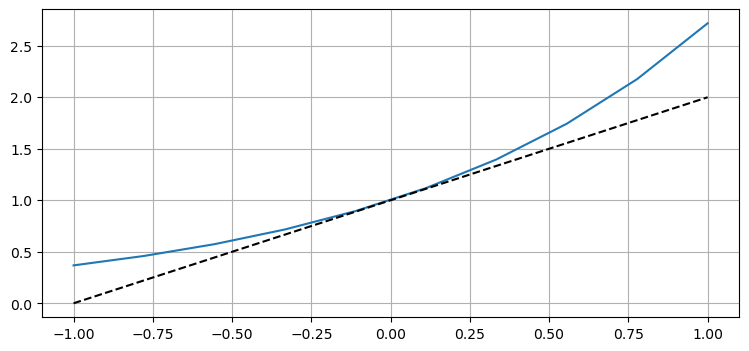

In [14]:
import matplotlib.pyplot as plt

t = np.linspace(-1, 1, 10)
plt.plot(t, np.exp(t))
t = np.linspace(-1, 1, 2)
plt.plot(t,t+1, ls='--', c='k');

Látható, hogy a lejtő nagyon közel van a $t=0,1$-nál lévő görbéhez, de távol van attól
$t=1$-nál. De folytassuk egy pillanatig 1-es lépésmérettel. Láthatjuk, hogy $t=1$-nál a $y$ becsült értéke 2. Most kiszámíthatjuk a $t=2$ értéket úgy, hogy a görbe meredekségét vesszük $t=1$-nál, és hozzáadjuk a kezdeti becslésünkhöz. A meredekség a $y'=y$ értékkel van kiszámítva, tehát a meredekség 2.

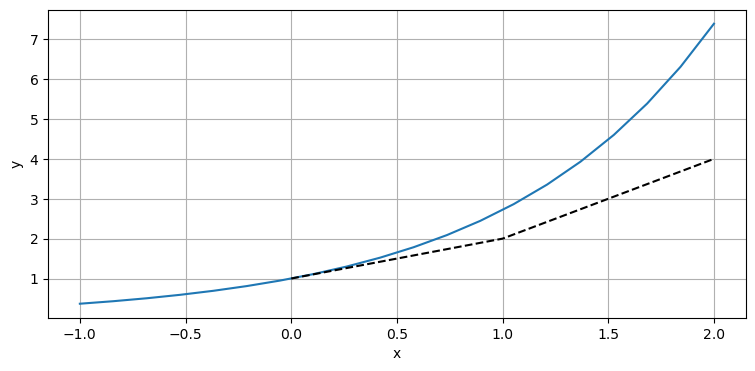

In [15]:
import kf_book.book_plots as book_plots

t = np.linspace(-1, 2, 20)
plt.plot(t, np.exp(t))
t = np.linspace(0, 1, 2)
plt.plot([1, 2, 4], ls='--', c='k')
book_plots.set_labels(x='x', y='y');

Itt azt látjuk, hogy y következő becslése 4. A hibák gyorsan nőnek, és lehet, hogy nem lesz hatással. De az 1 nagyon nagy lépésméret. Helyezzük ezt az algoritmust kódba, és kis lépésmérettel ellenőrizzük, hogy működik.

In [16]:
def euler(t, tmax, y, dx, step=1.):
    ys = []
    while t < tmax:
        y = y + step*dx(t, y)
        ys.append(y)
        t +=step        
    return ys

In [17]:
def dx(t, y): return y

print(euler(0, 1, 1, dx, step=1.)[-1])
print(euler(0, 2, 1, dx, step=1.)[-1])

2.0
4.0


Ez helyesnek tűnik. Tehát most ábrázoljuk egy sokkal kisebb lépésméret eredményét.

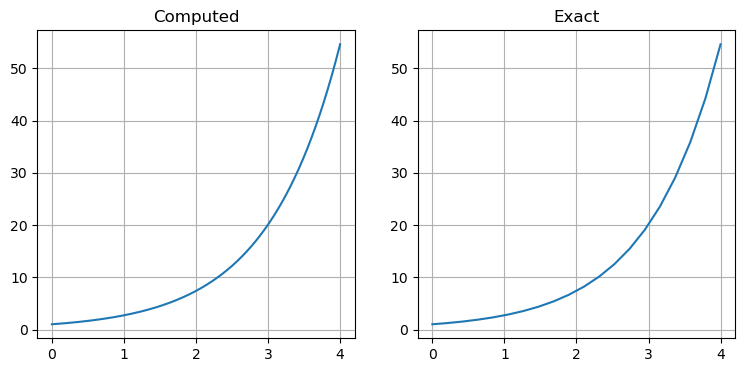

In [18]:
ys = euler(0, 4, 1, dx, step=0.00001)
plt.subplot(1,2,1)
plt.title('Computed')
plt.plot(np.linspace(0, 4, len(ys)),ys)
plt.subplot(1,2,2)
t = np.linspace(0, 4, 20)
plt.title('Exact')
plt.plot(t, np.exp(t));

In [19]:
print('exact answer=', np.exp(4))
print('euler answer=', ys[-1])
print('difference =', np.exp(4) - ys[-1])
print('iterations =', len(ys))

exact answer= 54.598150033144236
euler answer= 54.59705808834125
difference = 0.0010919448029866885
iterations = 400000


Itt azt látjuk, hogy a hiba meglehetősen kicsi, de nagyon sok iteráció kellett ahhoz, hogy három számjegyű pontosságot kapjunk. A gyakorlatban az Euler-féle módszer túl lassú a legtöbb problémához, és mi kifinomultabb módszereket alkalmazunk.

Mielőtt továbbmennénk, formálisan levezetjük az Euler-módszert, mivel ez az alapja a következő részben használt fejlettebb Runge Kutta-módszereknek. Valójában az Euler-módszer a Runge Kutta legegyszerűbb formája.


Íme az $y$ Taylor-kiterjesztésének első 3 feltétele. Egy végtelen bővítés pontos választ adna, ezért $O(h^4)$ jelöli a véges bővítés miatti hibát.

$$y(t_0 + h) = y(t_0) + h y'(t_0) + \frac{1}{2!}h^2 y''(t_0) + \frac{1}{3!}h^3 y'''(t_0) + O(h^4)$$

Itt láthatjuk, hogy az Euler-módszer a Taylor-kiterjesztés első két tagját használja. Minden következő tag kisebb, mint az előző tagok, így biztosak vagyunk abban, hogy a becslés nem lesz túl messze a helyes értéktől.

### Runge Kutta módszerek

A Runge Kutta a numerikus integráció igáslova. A szakirodalomban nagyon sok módszer található. A gyakorlatban az általam bemutatott Runge Kutta algoritmus a legtöbb problémát megoldja. Nagyon jó egyensúlyt kínál a sebesség, a pontosság és a stabilitás között, és ez a „menni” numerikus integrációs módszer, hacsak nincs jó okunk mást választani.

Merüljünk el. Kezdjük néhány differenciálegyenlettel

$$\ddot{y} = \frac{d}{dt}\dot{y}$$.

Az y deriváltját behelyettesíthetjük f függvénnyel, így

$$\ddot{y} = \frac{d}{dt}f(y,t)$$.

Ezen egyenletek levezetése kívül esik ennek a könyvnek a hatókörén, de a Runge Kutta RK4 módszert ezekkel az egyenletekkel definiáljuk.

$$y(t+\Delta t) = y(t) + \frac{1}{6}(k_1 + 2k_2 + 2k_3 + k_4) + O(\Delta t^4)$$

$$\begin{aligned}
k_1 &= f(y,t)\Delta t \\
k_2 &= f(y+\frac{1}{2}k_1, t+\frac{1}{2}\Delta t)\Delta t \\
k_3 &= f(y+\frac{1}{2}k_2, t+\frac{1}{2}\Delta t)\Delta t \\
k_4 &= f(y+k_3, t+\Delta t)\Delta t
\end{aligned}
$$

Itt van a megfelelő kód:

In [20]:
def runge_kutta4(y, x, dx, f):
    """computes 4th order Runge-Kutta for dy/dx.
    y is the initial value for y
    x is the initial value for x
    dx is the difference in x (e.g. the time step)
    f is a callable function (y, x) that you supply 
    to compute dy/dx for the specified values.
    """
    
    k1 = dx * f(y, x)
    k2 = dx * f(y + 0.5*k1, x + 0.5*dx)
    k3 = dx * f(y + 0.5*k2, x + 0.5*dx)
    k4 = dx * f(y + k3, x + dx)
    
    return y + (k1 + 2*k2 + 2*k3 + k4) / 6.

Használjuk ezt egy egyszerű példára. Hadd

$$\dot{y} = t\sqrt{y(t)}$$

a kezdeti értékekkel

$$\begin{aligned}t_0 &= 0\\y_0 &= y(t_0) = 1\end{aligned}$$

max error 0.00005


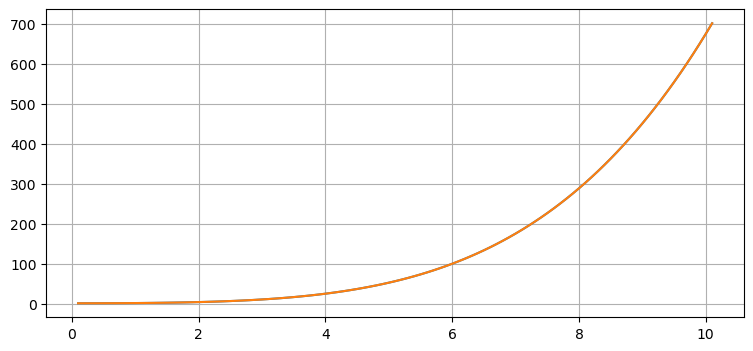

In [21]:
import math
import numpy as np
t = 0.
y = 1.
dt = .1

ys, ts = [], []

def func(y,t):
    return t*math.sqrt(y)

while t <= 10:
    y = runge_kutta4(y, t, dt, func)
    t += dt
    ys.append(y)
    ts.append(t)

exact = [(t**2 + 4)**2 / 16. for t in ts]
plt.plot(ts, ys)
plt.plot(ts, exact)

error = np.array(exact) - np.array(ys)
print(f"max error {max(error):.5f}")

## Bayesi szűrés

A Discrete Bayes fejezettől kezdve a szűréshez Bayes-féle formulációt használtam. Tegyük fel, hogy egy objektumot követünk. Meghatározzuk az *állapotát* egy adott időpontban, mint a helyzetét, sebességét stb. Például írhatjuk az állapotot időben$t$mint$\mathbf x_t = \begin{bmatrix}x_t &\dot x_t \end{bmatrix}^\mathsf T$. 

Amikor megmérjük az objektumot, akkor az állapotot vagy annak egy részét mérjük. Az érzékelők zajosak, ezért a mérést zaj rontja. Nyilvánvaló azonban, hogy a mérést az állam határozza meg. Vagyis az állapotváltozás megváltoztathatja a mérést, de a mérés változása nem változtatja meg az állapotot.

A szűrés során az a célunk, hogy optimális becslést számoljunk ki egy állapothalmazra$\mathbf x_{0:t}$0-ról időre$t$. Ha tudnánk$\mathbf x_{0:t}$akkor triviális lenne egy mérési halmazt kiszámítani$\mathbf z_{0:t}$megfelel azoknak az állapotoknak. Azonban kapunk egy méréssorozatot$\mathbf z_{0:t}$, és ki akarja számítani a megfelelő állapotokat$\mathbf x_{0:t}$. Ezt *statisztikai inverziónak* hívják, mert megpróbáljuk kiszámítani a bemenetet a kimenetből. 

Az inverzió nehéz probléma, mert jellemzően nincs egyedi megoldás. Egy adott állapothalmazhoz$\mathbf x_{0:t}$csak egy lehetséges mérési halmaz létezik (plusz zaj), de egy adott méréskészlethez sok különböző állapothalmaz létezik, amelyek ezekhez a mérésekhez vezethettek. 

Emlékezzünk Bayes-tételre:$$P(x \mid z) = \frac{P(z \mid x)P(x)}{P(z)}$$ahol$P(z \mid x)$a mérés *valószínűsége*$z$, $P(x)$a folyamatmodellünk alapján az *előzetes*, és$P(z)$egy normalizációs állandó.$P(x \mid z)$a *posterior*, vagy a mérés beépítése utáni eloszlás$z$, amelyet *bizonyítéknak* is neveznek.

Ez egy *statisztikai inverzió*$P(z \mid x)$hogy$P(x \mid z)$. A szűrési problémánk megoldása a következőképpen fejezhető ki:$$P(\mathbf x_{0:t} \mid \mathbf z_{0:t}) = \frac{P(\mathbf z_{0:t} \mid \mathbf x_{0:t})P(\mathbf x_{0:t})}{P(\mathbf z_{0:t})}$$Ez minden rendben van a következő mérésig$\mathbf z_{t+1}$bejön, ekkor újra kell számolnunk a tartomány teljes kifejezését$0:t+1$. 

A gyakorlatban ez megoldhatatlan, mert megpróbáljuk kiszámítani az utólagos eloszlást$P(\mathbf x_{0:t} \mid \mathbf z_{0:t})$az állapotra az időlépések teljes tartományában. De vajon tényleg érdekel minket a valószínűségi eloszlás a harmadik lépésnél (mondjuk), amikor éppen megkaptuk a tizedik mérést? Általában nem. Enyhítjük tehát követelményeinket, és csak az aktuális időlépés eloszlását számítjuk ki. 

Az első egyszerűsítés az, hogy folyamatunkat (például egy mozgó objektum mozgásmodelljét) *Markov-láncként* írjuk le. Vagyis azt mondjuk, hogy a jelenlegi állapot kizárólag az előző állapottól és az átmenet valószínűségétől függ$P(\mathbf x_k \mid \mathbf x_{k-1})$, ami csak annak a valószínűsége, hogy az utolsó állapotból a jelenlegi állapotba kerül. Ezt írjuk:$$\mathbf x_k \sim P(\mathbf x_k \mid \mathbf x_{k-1})$$A gyakorlatban ez rendkívül ésszerű, mivel sok dolog rendelkezik *Markov tulajdonsággal*. Ha egy parkolóban vezet, a következő másodpercben elfoglalt pozíciója attól függ, hogy egy perccel ezelőtt letért az államközi útról, vagy egy földúton kúszott-e? Nem. Az Ön pozíciója a következő másodpercben kizárólag az aktuális pozíciójától, a sebességétől és a vezérlő bemeneteitől függ, nem pedig attól, ami egy perce történt. Így az autók rendelkeznek Markov tulajdonsággal, és ezt az egyszerűsítést a pontosság és az általánosság elvesztése nélkül tehetjük meg.

A következő egyszerűsítésünk az, hogy a *mérési modellt* az aktuális állapottól függően határozzuk meg$\mathbf x_k$a mérés feltételes valószínűségével az aktuális állapot mellett:$P(\mathbf z_k \mid \mathbf x_k)$. Ezt írjuk:$$\mathbf z_k \sim P(\mathbf z_k \mid \mathbf x_k)$$Most ismétlődésünk van, ezért szükségünk van egy kezdeti feltételre a megszüntetéséhez. Ezért azt mondjuk, hogy a kezdeti eloszlás az állapot valószínűsége$\mathbf x_0$:

$$\mathbf x_0 \sim P(\mathbf x_0)$$Ezek a kifejezések be vannak kapcsolva a Bayes-egyenletbe. Ha megvan az állam$\mathbf x_0$és az első mérést, amit meg tudunk becsülni$P(\mathbf x_1 | \mathbf z_1)$. A mozgásmodell létrehozza az előzetest$P(\mathbf x_2 \mid \mathbf x_1)$. Ezt visszacsatoljuk a Bayes-tételbe a kiszámításhoz$P(\mathbf x_2 | \mathbf z_2)$. Folytatjuk ezt a prediktor-korrektor algoritmust, rekurzívan kiszámítva az állapotot és az időbeli eloszlást$t$kizárólag az aktuális állapoton és eloszláson alapul$t-1$és az időbeli mérés$t$.

A számítás matematikájának részletei a probléma függvényében változnak. A **Diszkrét Bayes** és az **Egyváltozós Kálmán-szűrő** fejezetek két különböző megfogalmazást adtak, amelyeket át kellett volna tudni gondolni. Az egyváltozós Kalman-szűrő feltételezi, hogy skaláris állapot esetén mind a zaj, mind a folyamat lineáris modell, amelyet nulla átlagú, nem korrelált Gauss-zaj befolyásol. 

A többváltozós Kálmán-szűrő ugyanezt a feltételezést teszi, de olyan állapotokra és mérésekre, amelyek vektorok, nem skalárok. Dr. Kalman be tudta bizonyítani, hogy ha ezek a feltételezések igazak, akkor a Kalman-szűrő *optimális* a legkisebb négyzetek értelmében. Köznyelvben ez azt jelenti, hogy a zajos mérésekből nem lehet több információt levonni. A könyv további részében olyan szűrőket mutatok be, amelyek enyhítik a linearitás és a Gauss-zaj korlátait.

Mielőtt továbbmennék, még néhány szó a statisztikai inverzióról. Ahogy Calvetti és Somersalo a *Bevezetés a bayesi tudományos számítástechnikába*-ban írják, "a bayesi nézőpontot alkalmazzuk: *a véletlenszerűség egyszerűen az információhiányt jelenti*"[3]. Állapotunk paraméterezi azokat a fizikai jelenségeket, amelyeket elvileg mérhetnénk vagy kiszámíthatnánk: sebesség, légellenállás stb. Nem áll rendelkezésünkre elegendő információ az értékük kiszámításához vagy méréséhez, ezért úgy döntünk, hogy véletlenszerű változóknak tekintjük őket. Szigorúan véve ezek nem véletlenszerűek, így ez szubjektív álláspont. 

Egy teljes fejezetet szentelnek ennek a témának. Megspórolhatok egy bekezdést. A Bayes-szűrők azért lehetségesek, mert statisztikai tulajdonságokat tulajdonítunk ismeretlen paramétereknek. A Kálmán-szűrő esetében zárt formájú megoldásaink vannak az optimális becslés megtalálására. Más szűrők, mint például a diszkrét Bayes szűrő vagy a részecskeszűrő, amelyről egy későbbi fejezetben foglalkozunk, ad-hoc, nem optimális módon modellezik a valószínűséget. Technikánk ereje abból adódik, hogy az információhiányt valószínűségi változóként kezeljük, ezt a valószínűségi változót valószínűségi eloszlásként írjuk le, majd a Bayes-tételt használjuk a statisztikai következtetési probléma megoldására.

## A Kalman-szűrő átalakítása g-h szűrővé

Kijelentettem, hogy a Kalman szűrő a g-h szűrő egyik formája. Csak némi algebra kell a bizonyításhoz. Ez egyszerűbb az egydimenziós tokkal, ezért megteszem. Visszahívás 

$$
\mu_{x}=\frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}
$$

amelyet barátságosabbá teszek a szemünk számára:

$$
\mu_{x}=\frac{ya + xb} {a+b}
$$

Ezt a következő algebrával könnyen beletehetjük a g-h alakba

$$
\begin{aligned}
\mu_{x}&=(x-x) + \frac{ya + xb} {a+b} \\
\mu_{x}&=x-\frac{a+b}{a+b}x  + \frac{ya + xb} {a+b} \\ 
\mu_{x}&=x +\frac{-x(a+b) + xb+ya}{a+b} \\
\mu_{x}&=x+ \frac{-xa+ya}{a+b}  \\
\mu_{x}&=x+ \frac{a}{a+b}(y-x)\\
\end{aligned}
$$

Már majdnem készen vagyunk, de ne feledjük, hogy a becslés szórását a 

$$\begin{aligned}
\sigma_{x}^2 &= \frac{1}{\frac{1}{\sigma_1^2} +  \frac{1}{\sigma_2^2}} \\
&= \frac{1}{\frac{1}{a} +  \frac{1}{b}}
\end{aligned}$$

Ezt a kifejezést beépíthetjük a fenti egyenletünkbe, ha ezt megfigyeljük

$$ 
\begin{aligned}
\frac{a}{a+b} &= \frac{a/a}{(a+b)/a} = \frac{1}{(a+b)/a}  \\
 &= \frac{1}{1 + \frac{b}{a}} = \frac{1}{\frac{b}{b} + \frac{b}{a}}  \\
 &= \frac{1}{b}\frac{1}{\frac{1}{b} + \frac{1}{a}} \\
 &= \frac{\sigma^2_{x}}{b}
 \end{aligned}
$$

Mindezt össze tudjuk kötni

$$
\begin{aligned}
\mu_{x}&=x+ \frac{a}{a+b}(y-x) \\
&= x + \frac{\sigma^2_{x}}{b}(y-x) \\
&= x + g_n(y-x)
\end{aligned}
$$

hol

$$g_n = \frac{\sigma^2_{x}}{\sigma^2_{y}}$$

A végeredmény az, hogy a két mérés maradékát megszorozzuk egy konstanssal, és hozzáadjuk az előző értékünket, amely a g-h szűrő $g$ egyenlete. $g$ az új becslés varianciája osztva a mérés szórásával. Természetesen ebben az esetben a $g$ nem konstans, mivel a variancia változásával minden időlépéssel változik. Ugyanígy származtathatjuk a $h$ képletét is. Nem különösebben megvilágosító levezetés, és kihagyom. A végeredmény az

$$h_n = \frac{COV (x,\dot x)}{\sigma^2_{y}}$$

A kiindulási pont az, hogy a $g$ és a $h$ teljes mértékben a mérés és a $n$ időpontbeli előrejelzések varianciája és kovarianciái által meghatározott. Más szóval, kiválasztunk egy pontot a mérés és az előrejelzés között egy skálafaktorral, amelyet e két bemenet minősége határoz meg.

## Hivatkozások

* [1] C.B. Molwer és C.F. Van Loan "Tizenkilenc kétes módszer egy mátrix exponenciális kiszámítására, huszonöt évvel később", *SIAM Review 45, 3-49*. 2003.


 * [2] C.F. van Loan, "Computing Integrals Involving the Matrix Exponential", IEEE *Transactions Automatic Control*, 1978. június.
 
 
 * [3] Calvetti, D és Somersalo E, "Bevezetés a bayesi tudományos számítástechnikába: tíz előadás a szubjektív számítástechnikáról", *Springer*, 2007.
 
 * [4] Brown, R. G. és Hwang, P. Y.C., "Introduction to Random Signals and Applied Kalman Filtering", *Wiley and Sons*, negyedik kiadás, 143-147. o., 2012.